<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 3. Обучение с учителем. Методы классификации
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/TBwVhQ).**

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

In [57]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [58]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [59]:
train_df = pd.read_csv("C:/Users/Иван/Downloads/train.csv")
test_df = pd.read_csv("C:/Users/Иван/Downloads/test.csv")

In [60]:
y = train_df["Survived"]

In [61]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [63]:
test_df.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Peter, Master. Michael J",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями.**

In [64]:
train_df["Age"]=train_df["Age"].fillna(train_df["Age"].median())
test_df["Age"]=test_df["Age"].fillna(train_df["Age"].median())
train_df["Embarked"]=train_df["Embarked"].fillna("S")
test_df["Fare"]=test_df["Fare"].fillna(train_df["Fare"].median())

**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [65]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["Pclass"], prefix="PClass"),
        pd.get_dummies(train_df["Sex"], prefix="Sex"),
        pd.get_dummies(train_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(train_df["Parch"], prefix="Parch"),
        pd.get_dummies(train_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

test_df = pd.concat(
    [
        test_df,
        pd.get_dummies(test_df["Pclass"], prefix="PClass"),
        pd.get_dummies(test_df["Sex"], prefix="Sex"),
        pd.get_dummies(test_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(test_df["Parch"], prefix="Parch"),
        pd.get_dummies(test_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

In [66]:
train_df.drop(
    [
        "Survived",
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)
test_df.drop(
    [
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [67]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [68]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [69]:
test_df.drop(["Parch_9"], axis=1, inplace=True)

In [70]:
train_df=train_df.astype(int)
test_df=test_df.astype(int)

In [71]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22,7,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,38,71,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,26,7,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35,53,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,35,8,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [72]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34,7,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,47,7,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62,9,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,27,8,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,22,12,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [74]:
clf=DecisionTreeClassifier(max_depth=2,random_state=17)
clf.fit(train_df,y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [76]:
clf_pred=clf.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [77]:
# Ваш код здесь(ЧЁЁ?)

<font color='red'>Вопрос 1. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?
- 0.746
- 0.756
- 0.766
- 0.776

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

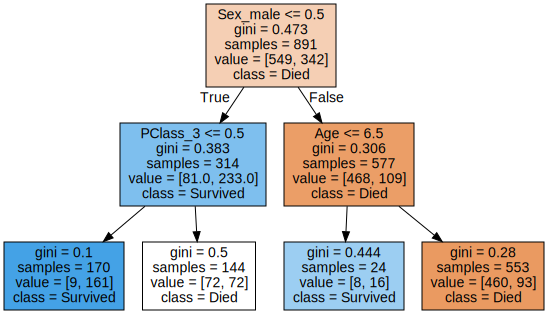

In [88]:
import graphviz
dot_data = export_graphviz(clf, feature_names=list(train_df.columns),class_names=['Died', 'Survived'], filled=True)
graph = graphviz.Source(dot_data)
graph

<font color='red'>Вопрос 2. </font> Сколько признаков задействуются при прогнозе деревом решений глубины 2?
- 2
- 3
- 4
- 5

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [91]:
# tree params for grid search
tree_params = {"max_depth": list(range(1, 5)), "min_samples_leaf": list(range(1, 5))}
grid_search_cv_clf=GridSearchCV(clf,tree_params,cv=5)
grid_search_cv_clf.fit(train_df, y)

,estimator,DecisionTreeC...ndom_state=17)
,param_grid,"{'max_depth': [1, 2, ...], 'min_samples_leaf': [1, 2, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?
- max_depth=2, min_samples_leaf=1
- max_depth=2, min_samples_leaf=4
- max_depth=3, min_samples_leaf=2
- max_depth=3, min_samples_leaf=3

In [92]:
grid_search_cv_clf.best_params_

{'max_depth': 4, 'min_samples_leaf': 1}

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?
- 0.77
- 0.79
- 0.81
- 0.83

In [107]:
print(f"{grid_search_cv_clf.best_score_:.2f}")

0.81


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [109]:
cv_clf_pred=grid_search_cv_clf.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle.**

In [ ]:
# Ваш код здесь

<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?
- 0.7499
- 0.7599
- 0.7699
- 0.7799

## Ссылки:

 - <a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster"
 - <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"